In [1]:
import os; os.makedirs("results", exist_ok=True)
import torch, torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

# Optional LPIPS toggle
USE_LPIPS = True

try:
    import lpips
    lpips_fn = lpips.LPIPS(net="alex").to(device) if USE_LPIPS else None
except Exception:
    lpips_fn = None
    print("LPIPS unavailable. Set USE_LPIPS=True and ‘pip install lpips‘ to enable.")
def load_rgb01():
    img = Image.fromarray(data.astronaut())
    x = T.ToTensor()(img).unsqueeze(0) # [1,3,H,W], [0,1]
    return x.to(device)
def psnr(ref, out, eps=1e-12):
    mse = F.mse_loss(out, ref)
    return (10 * torch.log10(1.0 / (mse + eps))).item()
def lpips_score(ref, out):
    if lpips_fn is None: return None
    with torch.no_grad():
        return lpips_fn(ref*2-1, out*2-1).mean().item()

x_clean = load_rgb01()
H, W = x_clean.shape[-2:]
print("Loaded image:", (H, W), "device:", device)
# save the image loaded 
plt.imsave("results/clean.png", x_clean[0].permute(1,2,0).cpu().numpy())


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


d:\Programmi\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programmi\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: d:\Programmi\Python\Lib\site-packages\lpips\weights\v0.1\alex.pth
Loaded image: (512, 512) device: cpu


In [2]:
# --- CHUNK 1: AWGN ---
def add_awgn(x, sigma=0.10):
    y = x + sigma * torch.randn_like(x)
    return y.clamp(0,1)

# sigmas = [0.03, 0.05, 0.10, 0.20]

# for sigma in sigmas:
#     y = add_awgn(x_clean, sigma=sigma)
#     psnr_val = psnr(x_clean, y)
#     lpips_val = lpips_score(x_clean, y)
#     print(f"Sigma={sigma} | AWGN PSNR:", psnr_val, "LPIPS:", lpips_val)
#     plt.figure(figsize=(9,3))
#     plt.subplot(1,3,1); plt.imshow(x_clean[0].permute(1,2,0).cpu()); plt.axis("off"); 
#     plt.title("Clean")
#     plt.subplot(1,3,2); plt.imshow(y[0].permute(1,2,0).cpu()); plt.axis("off"); 
#     plt.title(f"AWGN σ={sigma}\nPSNR: {psnr_val:.2f} | LPIPS: {lpips_val:.3f}")
#     plt.subplot(1,3,3); plt.imshow((y-x_clean)[0].permute(1,2,0).cpu()*0.5+0.5); 
#     plt.axis("off"); 
#     plt.title("Noise (scaled)")
#     plt.tight_layout(); plt.savefig(f"results/noise_awgn_sigma{sigma}.png", dpi=200); 
#     #plt.show()
#     plt.close()
    

In [3]:
#--- CHUNK 2: Poisson noise ---
def add_poisson(x, scale=255):
    vals = float(scale)
    noisy = torch.poisson(x * vals) / vals
    return noisy.clamp(0, 1)

scales = [15, 50, 110, 255]
for scale in scales:
    y = add_poisson(x_clean, scale=scale)
    psnr_val = psnr(x_clean, y)
    lpips_val = lpips_score(x_clean, y)
    print(f"Scale={scale} | Poisson PSNR:", psnr_val, "LPIPS:", lpips_val)
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(x_clean[0].permute(1,2,0).cpu()); plt.axis("off"); 
    plt.title("Clean")
    plt.subplot(1,3,2); plt.imshow(y[0].permute(1,2,0).cpu()); plt.axis("off"); 
    plt.title(f"Poisson scale={scale}\nPSNR: {psnr_val:.2f} | LPIPS: {lpips_val:.3f}")
    plt.subplot(1,3,3); plt.imshow((y-x_clean)[0].permute(1,2,0).cpu()*0.5+0.5); 
    plt.axis("off"); 
    plt.title("Noise (scaled)")
    plt.tight_layout(); plt.savefig(f"results/noise_poisson_scale{scale}.png", dpi=200); 
    #plt.show()
    plt.close()


Scale=15 | Poisson PSNR: 16.319095611572266 LPIPS: 0.697246253490448
Scale=50 | Poisson PSNR: 20.939542770385742 LPIPS: 0.43736737966537476
Scale=110 | Poisson PSNR: 24.128618240356445 LPIPS: 0.30831336975097656
Scale=255 | Poisson PSNR: 27.665115356445312 LPIPS: 0.1894313395023346


In [4]:
#--- CHUNK 3: Speckle noise (multiplicative) ---
def add_speckle(x, sigma=0.20):
    m = 1.0 + sigma * torch.randn_like(x)
    return (x * m).clamp(0, 1)

# sigmas = [0.10, 0.20, 0.30]

# for sigma in sigmas:
#     y = add_speckle(x_clean, sigma=sigma)
#     psnr_val = psnr(x_clean, y)
#     lpips_val = lpips_score(x_clean, y)
#     print(f"Sigma={sigma} | Speckle PSNR:", psnr_val, "LPIPS:", lpips_val)

#     plt.figure(figsize=(9, 3))
#     plt.subplot(1, 3, 1)
#     plt.imshow(x_clean[0].permute(1, 2, 0).cpu())
#     plt.axis("off")
#     plt.title("Clean")

#     plt.subplot(1, 3, 2)
#     plt.imshow(y[0].permute(1, 2, 0).cpu())
#     plt.axis("off")
#     plt.title(f"Speckle σ={sigma}\nPSNR: {psnr_val:.2f} | LPIPS: {lpips_val:.3f}")

#     plt.subplot(1, 3, 3)
#     plt.imshow((y - x_clean)[0].permute(1, 2, 0).cpu() * 0.5 + 0.5)
#     plt.axis("off")
#     plt.title("Noise (scaled)")

#     plt.tight_layout()
#     #plt.show()
#     plt.savefig(f"results/noise_speckle_sigma{sigma}.png", dpi=200)
#     plt.close()

In [5]:
# --- CHUNK 4: Salt & Pepper (impulse) ---
def add_salt_pepper(x, amount=0.05):
    # independent per-pixel, per-channel
    prob = torch.rand_like(x)
    y = x.clone()
    y[prob < amount/2] = 0.0
    y[(prob >= amount/2) & (prob < amount)] = 1.0
    return y

# amounts = [0.02, 0.05, 0.10]

# for amount in amounts:
#     y = add_salt_pepper(x_clean, amount=amount)
#     psnr_val = psnr(x_clean, y)
#     lpips_val = lpips_score(x_clean, y)
#     print(f"Amount={amount} | SaltPepper PSNR:", psnr_val, "LPIPS:", lpips_val)

#     plt.figure(figsize=(9, 3))
#     plt.subplot(1, 3, 1)
#     plt.imshow(x_clean[0].permute(1, 2, 0).cpu())
#     plt.axis("off")
#     plt.title("Clean")

#     plt.subplot(1, 3, 2)
#     plt.imshow(y[0].permute(1, 2, 0).cpu())
#     plt.axis("off")
#     plt.title(f"SaltPepper amt={amount}\nPSNR: {psnr_val:.2f} | LPIPS: {lpips_val:.3f}")

#     plt.subplot(1, 3, 3)
#     plt.imshow((y != x_clean).float()[0].mean(0).cpu(), vmin=0, vmax=1)
#     plt.axis("off")
#     plt.title("Changed pixels (mean)")

#     plt.tight_layout()
#     #plt.show()
#     plt.savefig(f"results/noise_saltpepper_amt{amount}.png", dpi=200)
#     plt.close()

In [9]:
# Create a single figure with all noise types
plt.figure(figsize=(20, 5))  # wider aspect for row layout

# AWGN
sigma_awgn = 0.10
y_awgn = add_awgn(x_clean, sigma=sigma_awgn)
psnr_awgn = psnr(x_clean, y_awgn)
lpips_awgn = lpips_score(x_clean, y_awgn)

plt.subplot(1, 4, 1)
plt.imshow(y_awgn[0].permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(f"AWGN (σ={sigma_awgn})\nPSNR: {psnr_awgn:.2f} dB\nLPIPS: {lpips_awgn:.3f}", 
          fontsize=12)

# Poisson
scale_poisson = 45
y_poisson = add_poisson(x_clean, scale=scale_poisson)
psnr_poisson = psnr(x_clean, y_poisson)
lpips_poisson = lpips_score(x_clean, y_poisson)

plt.subplot(1, 4, 2)
plt.imshow(y_poisson[0].permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(f"Poisson (scale={scale_poisson})\nPSNR: {psnr_poisson:.2f} dB\nLPIPS: {lpips_poisson:.3f}", 
          fontsize=12)

# Speckle
sigma_speckle = 0.18
y_speckle = add_speckle(x_clean, sigma=sigma_speckle)
psnr_speckle = psnr(x_clean, y_speckle)
lpips_speckle = lpips_score(x_clean, y_speckle)

plt.subplot(1, 4, 3)
plt.imshow(y_speckle[0].permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(f"Speckle (σ={sigma_speckle})\nPSNR: {psnr_speckle:.2f} dB\nLPIPS: {lpips_speckle:.3f}", 
          fontsize=12)

# Salt & Pepper
amount_sp = 0.025
y_sp = add_salt_pepper(x_clean, amount=amount_sp)
psnr_sp = psnr(x_clean, y_sp)
lpips_sp = lpips_score(x_clean, y_sp)

plt.subplot(1, 4, 4)
plt.imshow(y_sp[0].permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(f"Salt & Pepper (amount={amount_sp})\nPSNR: {psnr_sp:.2f} dB\nLPIPS: {lpips_sp:.3f}", 
          fontsize=12)

plt.tight_layout()
plt.savefig("results/all_noise_types_comparison_row.png", dpi=150, bbox_inches='tight')
plt.close()

print("Comparison image saved as 'results/all_noise_types_comparison_row.png'")


Comparison image saved as 'results/all_noise_types_comparison_row.png'


In [19]:
# --- CHUNK 5: Mean filter ---
def mean_filter(x, k=5):
    pad = k // 2
    kernel = torch.ones((1, 1, k, k), device=x.device) / (k * k)
    kernel = kernel.repeat(x.shape[1], 1, 1, 1)  # per-channel
    xp = F.pad(x, (pad, pad, pad, pad), mode="reflect")
    return F.conv2d(xp, kernel, groups=x.shape[1])

noisy_images = {
    "AWGN": (add_awgn(x_clean, sigma=0.10), "σ=0.10"),
    "Poisson": (add_poisson(x_clean, scale=255), "scale=255"),
    "Speckle": (add_speckle(x_clean, sigma=0.20), "σ=0.20"),
    "Salt_Pepper": (add_salt_pepper(x_clean, amount=0.05), "amount=0.05")
}

k_list = [3, 5, 7, 11]

# Process each noisy image type
for noise_name, (noisy, param_str) in noisy_images.items():
    print(f"\n=== Processing {noise_name} noise ({param_str}) ===")
    
    for k in k_list:
        den = mean_filter(noisy, k=k)
        psnr_val = psnr(x_clean, den)
        lpips_val = lpips_score(x_clean, den)
        print(f"Mean(k={k}) PSNR:", psnr_val, "LPIPS:", lpips_val)

        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(noisy[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title(f"{noise_name} Noisy\n({param_str})")

        plt.subplot(1, 3, 2)
        plt.imshow(den[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title(f"Mean k={k}\nPSNR: {psnr_val:.2f} | LPIPS: {lpips_val:.3f}")

        plt.subplot(1, 3, 3)
        plt.imshow(x_clean[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Clean")

        plt.tight_layout()
        # Create results directory if it doesn't exist
        os.makedirs("results", exist_ok=True)
        plt.savefig(f"results/mean_{noise_name}_k{k}.png", dpi=200, bbox_inches='tight')
        plt.close()

print("\n=== All processing complete! ===")


=== Processing AWGN noise (σ=0.10) ===
Mean(k=3) PSNR: 26.393657684326172 LPIPS: 0.30617445707321167
Mean(k=5) PSNR: 24.95111846923828 LPIPS: 0.3240576982498169
Mean(k=7) PSNR: 23.4372501373291 LPIPS: 0.3743492364883423
Mean(k=11) PSNR: 21.31847381591797 LPIPS: 0.4595264196395874

=== Processing Poisson noise (scale=255) ===
Mean(k=3) PSNR: 29.102060317993164 LPIPS: 0.16703176498413086
Mean(k=5) PSNR: 25.916040420532227 LPIPS: 0.25589272379875183
Mean(k=7) PSNR: 23.99224281311035 LPIPS: 0.33173617720603943
Mean(k=11) PSNR: 21.6402587890625 LPIPS: 0.4413810670375824

=== Processing Speckle noise (σ=0.20) ===
Mean(k=3) PSNR: 26.275726318359375 LPIPS: 0.3083597719669342
Mean(k=5) PSNR: 25.064897537231445 LPIPS: 0.34444284439086914
Mean(k=7) PSNR: 23.56267738342285 LPIPS: 0.39355888962745667
Mean(k=11) PSNR: 21.42289161682129 LPIPS: 0.467803418636322

=== Processing Salt_Pepper noise (amount=0.05) ===
Mean(k=3) PSNR: 24.787887573242188 LPIPS: 0.41293439269065857
Mean(k=5) PSNR: 24.4487380

In [20]:
# --- CHUNK 6: Median filter ---
def median_filter(x, k=5):
    pad = k // 2
    xp = F.pad(x, (pad, pad, pad, pad), mode="reflect")
    patches = xp.unfold(2, k, 1).unfold(3, k, 1)  # [B,C,H,W,k,k]
    patches = patches.contiguous().view(x.shape[0], x.shape[1], x.shape[2], x.shape[3], -1)
    return patches.median(dim=-1).values

# Create all noisy versions with their parameters
noisy_images = {
    "AWGN": (add_awgn(x_clean, sigma=0.10), "σ=0.10"),
    "Poisson": (add_poisson(x_clean, scale=255), "scale=255"),
    "Speckle": (add_speckle(x_clean, sigma=0.20), "σ=0.20"),
    "Salt_Pepper": (add_salt_pepper(x_clean, amount=0.05), "amount=0.05")
}

k_list = [3, 5, 7, 11]

# Process each noisy image type
for noise_name, (noisy, param_str) in noisy_images.items():
    print(f"\n=== Processing {noise_name} noise ({param_str}) ===")
    
    for k in k_list:
        den = median_filter(noisy, k=k)
        psnr_val = psnr(x_clean, den)
        lpips_val = lpips_score(x_clean, den)
        print(f"Median(k={k}) PSNR:", psnr_val, "LPIPS:", lpips_val)

        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(noisy[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title(f"{noise_name} Noisy\n({param_str})")

        plt.subplot(1, 3, 2)
        plt.imshow(den[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title(f"Median k={k}\nPSNR: {psnr_val:.2f} | LPIPS: {lpips_val:.3f}")

        plt.subplot(1, 3, 3)
        plt.imshow(x_clean[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Clean")

        plt.tight_layout()
        # Create results directory if it doesn't exist
        os.makedirs("results", exist_ok=True)
        plt.savefig(f"results/median_{noise_name}_k{k}.png", dpi=200, bbox_inches='tight')
        plt.close()

print("\n=== All median filter processing complete! ===")


=== Processing AWGN noise (σ=0.10) ===
Median(k=3) PSNR: 26.24799919128418 LPIPS: 0.29034513235092163
Median(k=5) PSNR: 26.169601440429688 LPIPS: 0.2554141581058502
Median(k=7) PSNR: 25.00383758544922 LPIPS: 0.27373218536376953
Median(k=11) PSNR: 22.916412353515625 LPIPS: 0.3272703289985657

=== Processing Poisson noise (scale=255) ===
Median(k=3) PSNR: 30.030723571777344 LPIPS: 0.1122855544090271
Median(k=5) PSNR: 27.588085174560547 LPIPS: 0.13878685235977173
Median(k=7) PSNR: 25.704500198364258 LPIPS: 0.18316078186035156
Median(k=11) PSNR: 23.26349639892578 LPIPS: 0.2657160758972168

=== Processing Speckle noise (σ=0.20) ===
Median(k=3) PSNR: 25.552871704101562 LPIPS: 0.2935294210910797
Median(k=5) PSNR: 25.780994415283203 LPIPS: 0.2724476158618927
Median(k=7) PSNR: 24.710569381713867 LPIPS: 0.2832934558391571
Median(k=11) PSNR: 22.686626434326172 LPIPS: 0.3298527002334595

=== Processing Salt_Pepper noise (amount=0.05) ===
Median(k=3) PSNR: 31.44095230102539 LPIPS: 0.05477735400199


=== Processing AWGN noise (σ=0.10) ===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08261669..1.0836992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051145185..1.0593065].


Bicubic(a=-0.5) PSNR: 22.896259307861328 LPIPS: 0.3955155313014984


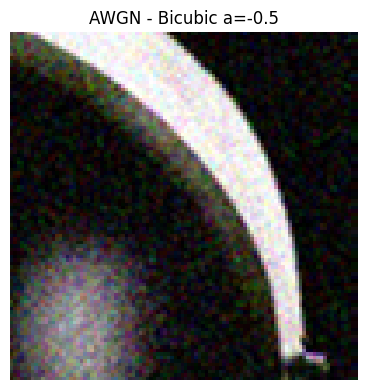

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12609984..1.1430625].


Bicubic(a=-0.75) PSNR: 22.14391326904297 LPIPS: 0.4229717254638672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07886516..1.0906867].


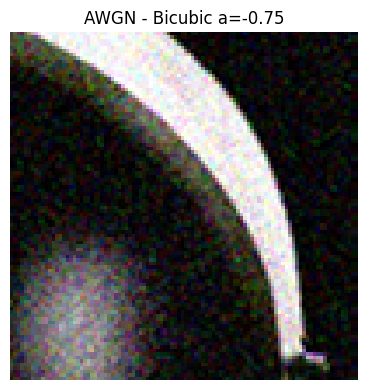

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17103289..1.2280985].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11478316..1.1284099].


Bicubic(a=-1) PSNR: 21.350997924804688 LPIPS: 0.45028257369995117


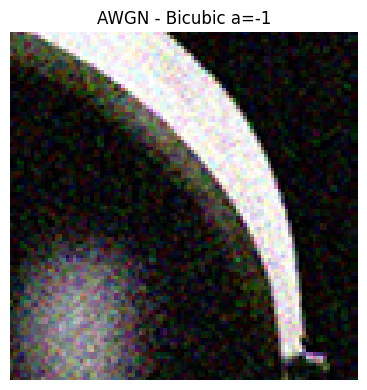

Bicubic(a=0) PSNR: 24.192094802856445 LPIPS: 0.3414677679538727


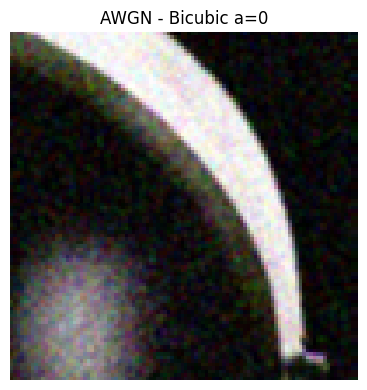


=== Processing Poisson noise (scale=255) ===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051378682..1.0606618].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047074143..1.0299478].


Bicubic(a=-0.5) PSNR: 26.496498107910156 LPIPS: 0.14852306246757507


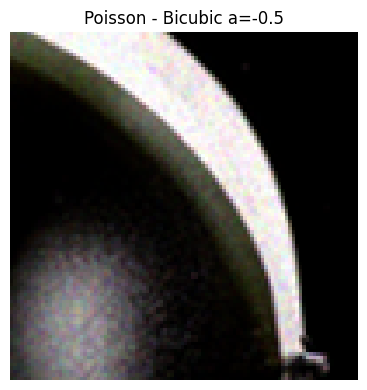

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07911687..1.0963197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.072809435..1.0576323].


Bicubic(a=-0.75) PSNR: 26.009353637695312 LPIPS: 0.16337765753269196


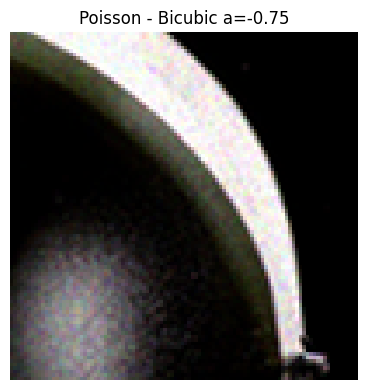

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10949756..1.143321].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.102696076..1.0939339].


Bicubic(a=-1) PSNR: 25.440093994140625 LPIPS: 0.18069788813591003


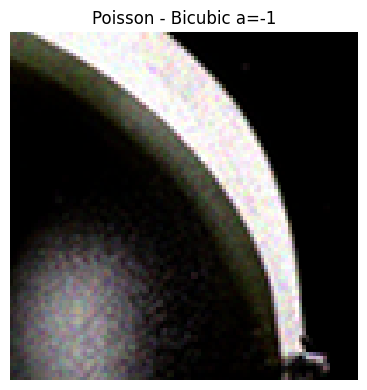

Bicubic(a=0) PSNR: 27.160837173461914 LPIPS: 0.13194844126701355


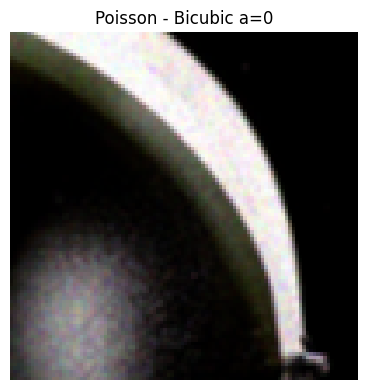


=== Processing Speckle noise (σ=0.20) ===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.060015652..1.1077901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.052924246..1.0634297].


Bicubic(a=-0.5) PSNR: 22.380544662475586 LPIPS: 0.38645780086517334


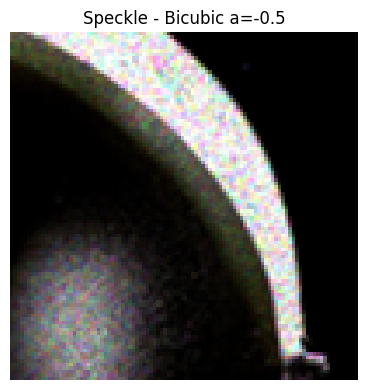

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.095597334..1.1639473].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08335156..1.1056256].


Bicubic(a=-0.75) PSNR: 21.575096130371094 LPIPS: 0.41426748037338257


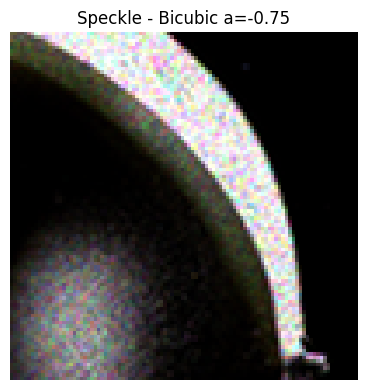

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13200766..1.2216126].


Bicubic(a=-1) PSNR: 20.73929214477539 LPIPS: 0.4428136348724365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1170487..1.1508688].


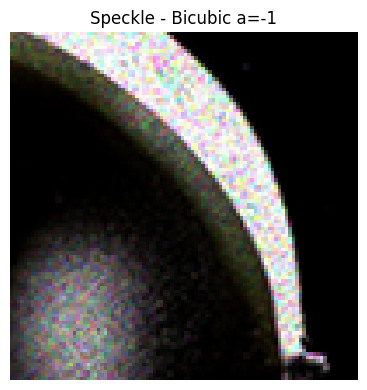

Bicubic(a=0) PSNR: 23.81284523010254 LPIPS: 0.33447831869125366


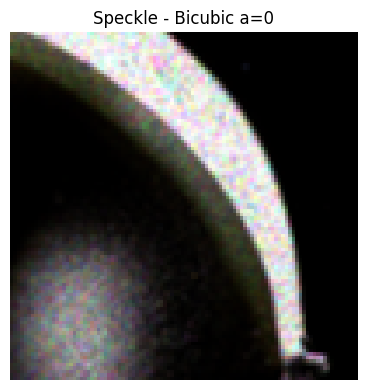


=== Processing Salt_Pepper noise (amount=0.05) ===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19217218..1.1023592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.110891536..1.1006588].


Bicubic(a=-0.5) PSNR: 20.52004051208496 LPIPS: 0.5467376112937927


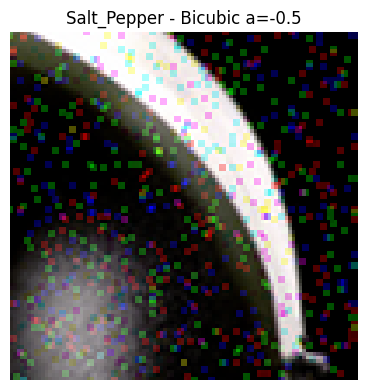

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2987477..1.180216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17499615..1.1614392].


Bicubic(a=-0.75) PSNR: 19.64297103881836 LPIPS: 0.5806853175163269


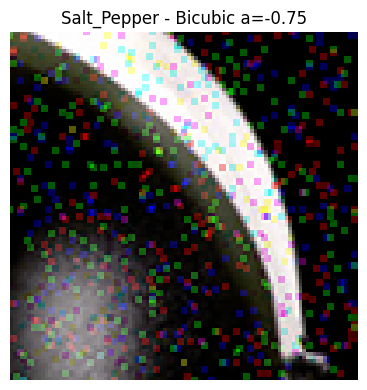

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41231617..1.2631127].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24454656..1.2278799].


Bicubic(a=-1) PSNR: 18.751209259033203 LPIPS: 0.6156195998191833


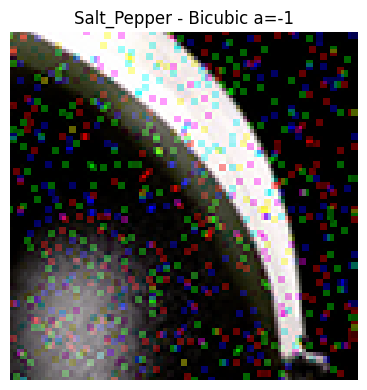

Bicubic(a=0) PSNR: 22.150936126708984 LPIPS: 0.47935372591018677


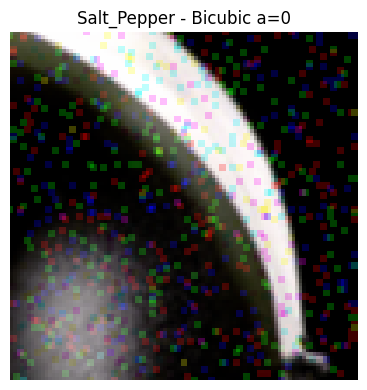


=== All bicubic filter processing complete! ===


In [12]:
# --- CHUNK 7: Bicubic-like 4x4 kernel ---
def cubic_weight(x, a=-0.5):
    ax = abs(x)
    if ax < 1:
        return (a + 2) * ax**3 - (a + 3) * ax**2 + 1
    if ax < 2:
        return a * ax**3 - 5 * a * ax**2 + 8 * a * ax - 4 * a
    return 0.0

def bicubic_filter(x, a=-0.5):
    xs = [-1.5, -0.5, 0.5, 1.5]
    w1 = torch.tensor([cubic_weight(t, a=a) for t in xs], device=x.device, dtype=x.dtype)
    w1 = w1 / (w1.sum() + 1e-12)
    k2d = (w1[:, None] @ w1[None, :]).unsqueeze(0).unsqueeze(0)  # [1,1,4,4]
    k2d = k2d.repeat(x.shape[1], 1, 1, 1)
    pad_l, pad_r = 1, 2
    xp = F.pad(x, (pad_l, pad_r, pad_l, pad_r), mode="reflect")
    return F.conv2d(xp, k2d, groups=x.shape[1])

# Create all noisy versions with their parameters
noisy_images = {
    "AWGN": (add_awgn(x_clean, sigma=0.10), "σ=0.10"),
    "Poisson": (add_poisson(x_clean, scale=255), "scale=255"),
    "Speckle": (add_speckle(x_clean, sigma=0.20), "σ=0.20"),
    "Salt_Pepper": (add_salt_pepper(x_clean, amount=0.05), "amount=0.05")
}

a_list = [-0.5, -0.75, -1, 0]
crop_size = 100
h, w = x_clean.shape[2], x_clean.shape[3]


# Process each noisy image type
for noise_name, (noisy, param_str) in noisy_images.items():
    print(f"\n=== Processing {noise_name} noise ({param_str}) ===")
    
    for a in a_list:
        den = bicubic_filter(noisy, a=a)
        psnr_val = psnr(x_clean, den)
        lpips_val = lpips_score(x_clean, den)
        print(f"Bicubic(a={a}) PSNR:", psnr_val, "LPIPS:", lpips_val)

        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(noisy[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title(f"{noise_name} Noisy\n({param_str})")

        plt.subplot(1, 3, 2)
        plt.imshow(den[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title(f"Bicubic a={a}\nPSNR: {psnr_val:.2f} | LPIPS: {lpips_val:.3f}")

        plt.subplot(1, 3, 3)
        plt.imshow(x_clean[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Clean")

        plt.tight_layout()
        # Create results directory if it doesn't exist
        # os.makedirs("results", exist_ok=True)
        # plt.savefig(f"results/bicubic_{noise_name}_a{a}.png", dpi=200, bbox_inches='tight')
        plt.close()
        den_crop = den[0, :, h-crop_size-50:h-50, w-crop_size:w].permute(1, 2, 0).cpu()
        plt.figure(figsize=(4, 4))
        plt.imshow(den_crop)
        plt.axis('off')
        plt.title(f'{noise_name} - Bicubic a={a}')
        plt.tight_layout()
        plt.show()

print("\n=== All bicubic filter processing complete! ===")

In [22]:
# --- CHUNK 8: Bilateral (naive) ---
def bilateral_filter(x, ksize=7, sigma_space=2.0, sigma_color=0.10):
    assert x.shape[0] == 1, "Use batch=1 for this demo."
    pad = ksize // 2
    xp = F.pad(x, (pad, pad, pad, pad), mode="reflect")
    _, C, H, W = x.shape
    coords = torch.arange(ksize, device=x.device) - pad
    X, Y = torch.meshgrid(coords, coords, indexing="ij")
    spatial = torch.exp(-(X**2 + Y**2) / (2 * sigma_space**2))
    out = torch.zeros_like(x)
    
    for i in range(H):
        for j in range(W):
            patch = xp[0, :, i:i+ksize, j:j+ksize]  # CxKxK
            center = x[0, :, i, j].view(C, 1, 1)  # Cx1x1
            # Range kernel over RGB; squared L2 across channels
            range_w = torch.exp(-((patch - center).pow(2).sum(dim=0)) / (2 * sigma_color**2))
            
            w = spatial * range_w
            w = w / (w.sum() + 1e-12)
            out[0, :, i, j] = (patch * w).sum(dim=(1, 2))
    
    return out

# Create all noisy versions with their parameters
noisy_images = {
    "AWGN": (add_awgn(x_clean, sigma=0.10), "σ=0.10"),
    "Poisson": (add_poisson(x_clean, scale=255), "scale=255"),
    "Speckle": (add_speckle(x_clean, sigma=0.20), "σ=0.20"),
    "Salt_Pepper": (add_salt_pepper(x_clean, amount=0.05), "amount=0.05")
}

# Settings for each case: (ksize, sigma_space, sigma_color)
oversmooth_settings = (7, 3.0, 0.20)  # Large kernel, high spatial sigma, high color sigma
preserve_edges_settings = (5, 1.5, 0.05)  # Medium kernel, moderate spatial sigma, low color sigma

# Process each noisy image type
for noise_name, (noisy, param_str) in noisy_images.items():
    print(f"\n=== Processing {noise_name} noise ({param_str}) ===")
    
    # Case 1: Oversmoothing
    ksize, s_space, s_color = oversmooth_settings
    den_oversmooth = bilateral_filter(noisy, ksize=ksize, sigma_space=s_space, sigma_color=s_color)
    psnr_oversmooth = psnr(x_clean, den_oversmooth)
    lpips_oversmooth = lpips_score(x_clean, den_oversmooth)
    print(f"Oversmooth (k={ksize}, ss={s_space}, sc={s_color}) PSNR: {psnr_oversmooth:.2f}, LPIPS: {lpips_oversmooth:.3f}")
    
    # Case 2: Edge preservation with residual noise
    ksize, s_space, s_color = preserve_edges_settings
    den_preserve = bilateral_filter(noisy, ksize=ksize, sigma_space=s_space, sigma_color=s_color)
    psnr_preserve = psnr(x_clean, den_preserve)
    lpips_preserve = lpips_score(x_clean, den_preserve)
    print(f"Preserve edges (k={ksize}, ss={s_space}, sc={s_color}) PSNR: {psnr_preserve:.2f}, LPIPS: {lpips_preserve:.3f}")
    
    # Create comparison figure with both results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(noisy[0].permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(f"{noise_name} Noisy\n({param_str})")
    
    k_ov, ss_ov, sc_ov = oversmooth_settings
    plt.subplot(1, 4, 2)
    plt.imshow(den_oversmooth[0].permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(f"Oversmooth\nk={k_ov}, σs={ss_ov}, σc={sc_ov}\nPSNR: {psnr_oversmooth:.2f}\nLPIPS: {lpips_oversmooth:.3f}")
    
    k_pr, ss_pr, sc_pr = preserve_edges_settings
    plt.subplot(1, 4, 3)
    plt.imshow(den_preserve[0].permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(f"Preserve edges\nk={k_pr}, σs={ss_pr}, σc={sc_pr}\nPSNR: {psnr_preserve:.2f}\nLPIPS: {lpips_preserve:.3f}")
    
    plt.subplot(1, 4, 4)
    plt.imshow(x_clean[0].permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title("Clean")
    
    plt.tight_layout()
    # Create results directory if it doesn't exist
    os.makedirs("results", exist_ok=True)
    plt.savefig(f"results/bilateral_{noise_name}_comparison.png", dpi=200, bbox_inches='tight')
    plt.close()

print("\n=== All bilateral filter comparisons complete! ===")


=== Processing AWGN noise (σ=0.10) ===
Oversmooth (k=7, ss=3.0, sc=0.2) PSNR: 28.04, LPIPS: 0.186
Preserve edges (k=5, ss=1.5, sc=0.05) PSNR: 20.99, LPIPS: 0.477

=== Processing Poisson noise (scale=255) ===
Oversmooth (k=7, ss=3.0, sc=0.2) PSNR: 32.60, LPIPS: 0.085
Preserve edges (k=5, ss=1.5, sc=0.05) PSNR: 29.55, LPIPS: 0.142

=== Processing Speckle noise (σ=0.20) ===
Oversmooth (k=7, ss=3.0, sc=0.2) PSNR: 26.03, LPIPS: 0.266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


Preserve edges (k=5, ss=1.5, sc=0.05) PSNR: 20.08, LPIPS: 0.465

=== Processing Salt_Pepper noise (amount=0.05) ===
Oversmooth (k=7, ss=3.0, sc=0.2) PSNR: 17.97, LPIPS: 0.664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


Preserve edges (k=5, ss=1.5, sc=0.05) PSNR: 17.47, LPIPS: 0.663

=== All bilateral filter comparisons complete! ===
